# Evolution of the attack and defense parameters
I'm interested in how the modelled defense and attack parameters evolve from week to week for a team that has just joined the premiership and for one who has been in there a while. 

In the 21/22 year Nowrich City (NOR) and Brentwood (BRE) were promoted to the Premier League - Brentwood had not been in there before. Manchester City and United had been in the premiership for a while.

This was made using a database containing 7 years worth of game data
```
airsenal_env set -k FPL_TEAM_ID -v 2779516

airsenal_setup_initial_db --n_previous 7 --clean
```

In [1]:
from airsenal.framework.utils import *
from airsenal.framework.bpl_interface import get_fitted_team_model, get_training_data, create_and_fit_team_model
from airsenal.framework.season import get_current_season, get_teams_for_season

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import jax.numpy as jnp

%matplotlib inline

In [46]:
team_colours={}
team_colours['BRE'] = 'red'
team_colours['NOR'] = 'gold'
team_colours['MCI'] = 'blue'
team_colours['MUN'] = 'red'

Make a model for the 21/22 season, and look at the first game week

In [3]:
season = "2122"
gameweek = 1

In [4]:
model_team = get_fitted_team_model(season = season,
                                   gameweek = gameweek,
                                   dbsession = session)

Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:12<00:00, 119.91it/s, 127 steps of size 4.45e-02. acc. prob=0.94]


Adding BRE to team model with covariates


In [5]:
current_teams = get_teams_for_season(season, session)

# Get the index of the teams who are present in this season with respect to the team model
current_idx = {team: idx for idx, team in enumerate(model_team.teams)
               if team in current_teams}

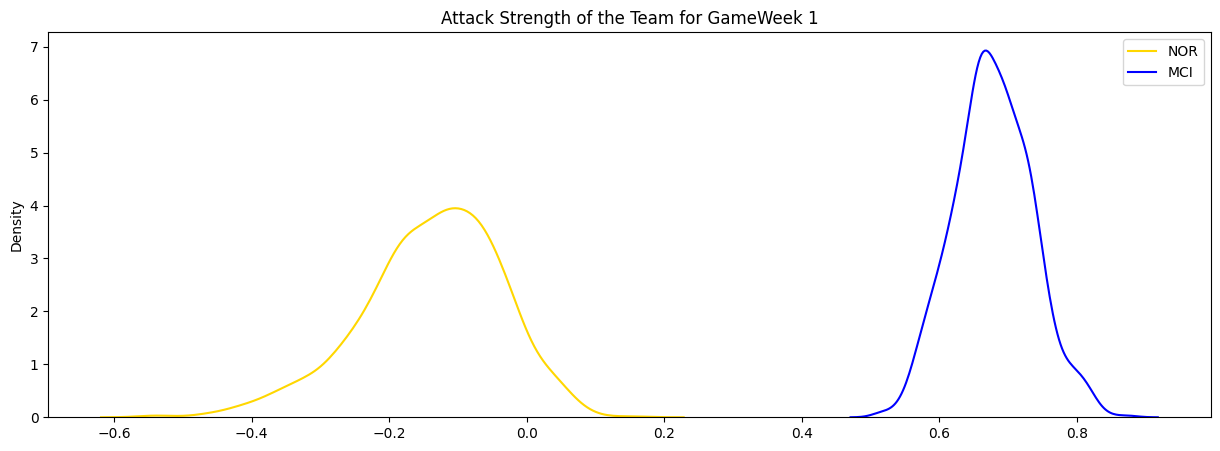

In [6]:
# Plot the attack parameter after game week 1
ax = plt.figure(figsize=(15, 5)).gca()
for team in ['NOR', 'MCI']:
    sns.kdeplot(model_team.attack[:, current_idx[team]], label=team, color = team_colours[team])
plt.title('Attack Strength of the Team for GameWeek 1')
plt.legend()
plt.show()

## Look at the first 5 weeks of the season

In [7]:
season = "2122"
gameweeks = [1, 2, 3, 4, 5]

models = {gw: get_fitted_team_model(season, gw, session) for gw in gameweeks}
# teams = get_teams_for_season(season, session)

Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:12<00:00, 120.35it/s, 127 steps of size 4.45e-02. acc. prob=0.94]


Adding BRE to team model with covariates
Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:12<00:00, 120.62it/s, 127 steps of size 4.53e-02. acc. prob=0.94]


Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:10<00:00, 146.17it/s, 127 steps of size 5.22e-02. acc. prob=0.91]


Fitting team model...


sample: 100%|█████████████████████████████████████████| 1500/1500 [00:10<00:00, 148.52it/s, 63 steps of size 5.69e-02. acc. prob=0.90]


Fitting team model...


sample: 100%|█████████████████████████████████████████| 1500/1500 [00:10<00:00, 147.82it/s, 63 steps of size 5.62e-02. acc. prob=0.90]


In [8]:
def plot_team_attack(models_dict, team_list):
    ax = plt.figure(figsize=(15, 5)).gca()
    for team in team_list:
        if team not in team_colours.keys():
            team_colours[team] = "gray"
        team_palette = sns.color_palette(f"dark:{team_colours[team]}_r", len(models_dict.keys()))
        col_idx = 0
        for gw, m in models_dict.items():
            sns.kdeplot(m.attack[:, m.teams.index(team)],
                       label=f"{team}: wk {gw}",
                       color=team_palette[col_idx])
            col_idx += 1
    plt.title(f'Attack Strength of the Team for GameWeek {min(models_dict.keys())} - {max(models_dict.keys())}')
    plt.legend()
    plt.show()

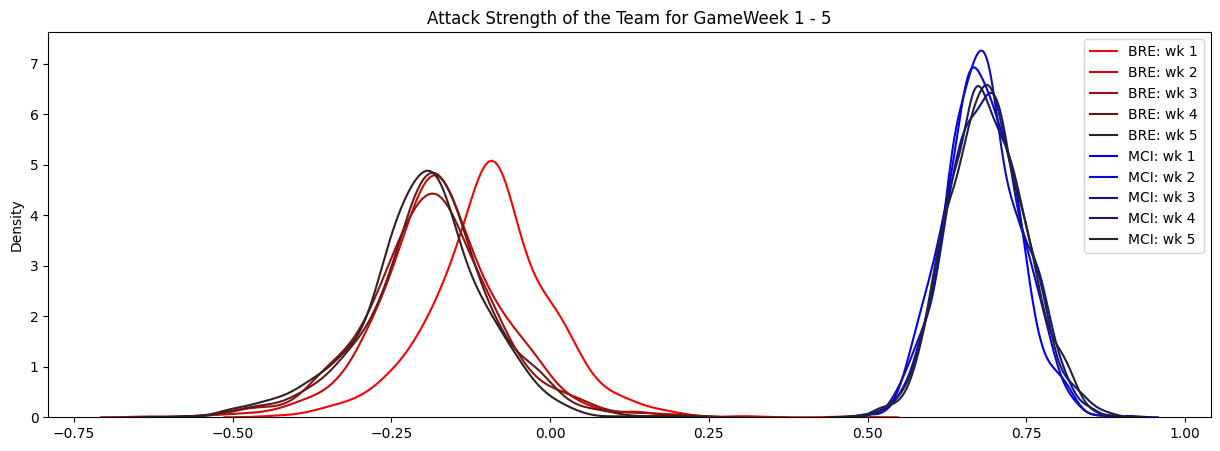

In [9]:
plot_team_attack(models, ["BRE", "MCI"])

In [10]:
def plot_averages(models_dict, team_list):
    x = list(models_dict.keys())    
    ax = plt.figure(figsize=(15, 5)).gca()
    for team in team_list:
        if team not in team_colours.keys():
            team_colours[team] = "gray"
        mean_att = []
        ul = []
        ll = []
        for gw, m in models_dict.items():
            mn = m.attack[:,m.teams.index(team)].mean()
            ul.append(mn + np.std(m.attack[:,m.teams.index(team)]))
            ll.append(mn - np.std(m.attack[:,m.teams.index(team)]))
            mean_att.append(mn)
        plt.plot(x,
                 mean_att,
                 label=team,
                 marker="^",
                 color=team_colours[team]
                )
        plt.fill_between(x, ul, ll, facecolor=team_colours[team], alpha=.15)

    plt.title(f"Mean of the attack parameter for {', '.join(team_list)}")
    plt.xlabel("Game Week")
    plt.ylabel("Team Attack Parameter")

    plt.legend()
    plt.show()

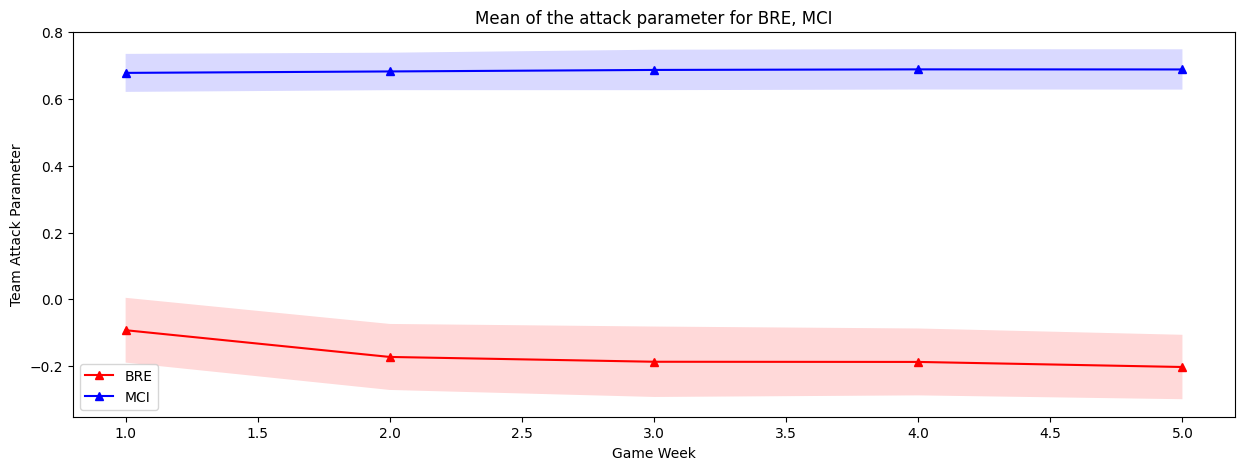

In [11]:
plot_averages(models, ["BRE", "MCI"])

## Setting the ratings as false - still in the first 5 weeks only
What does the data look like when the team ratings aren't included in calculations. 

This means that teams who are brand new to the Premiership will not be included in the team list as there will be no information for the priors.


When fitting a model the fifa ratings won't get passed to the model. We predict that the effect of this on the teams will be negligable as they are only used for priors, and we have at least 1 season of data for any team left in the teams list

In this example we will compare Manchester City both with and without the contribution of the weighting, and also Norwich City - who had previously been in the Priemiership and relegated, but were promoted for the 21/22 season.

In [12]:
from airsenal.framework.bpl_interface import  get_result_dict
def notebook_get_training_data(season, gameweek, dbsession, ratings=False): #TODO Change back to False
    training_data = get_result_dict(season, gameweek, dbsession)
    if ratings:
        teams = set(training_data["home_team"]) | set(training_data["away_team"])
        training_data["team_covariates"] = get_ratings_dict(season, teams, dbsession)
    return training_data




In [13]:
no_rate_models = {}
gwks = [1,2,3,4,5]
for gw in gwks:
    # Making the model - this time we use the two preccursor functions from
    # get_fitted_team_model - as we aren't adding new teams
    
    training_data = notebook_get_training_data(season = "2122",
                                      gameweek = gw,
                                      dbsession = session)
    no_rate_models[gw] = create_and_fit_team_model(training_data) 

sample: 100%|█████████████████████████████████████████| 1500/1500 [00:05<00:00, 259.94it/s, 31 steps of size 1.78e-01. acc. prob=0.90]


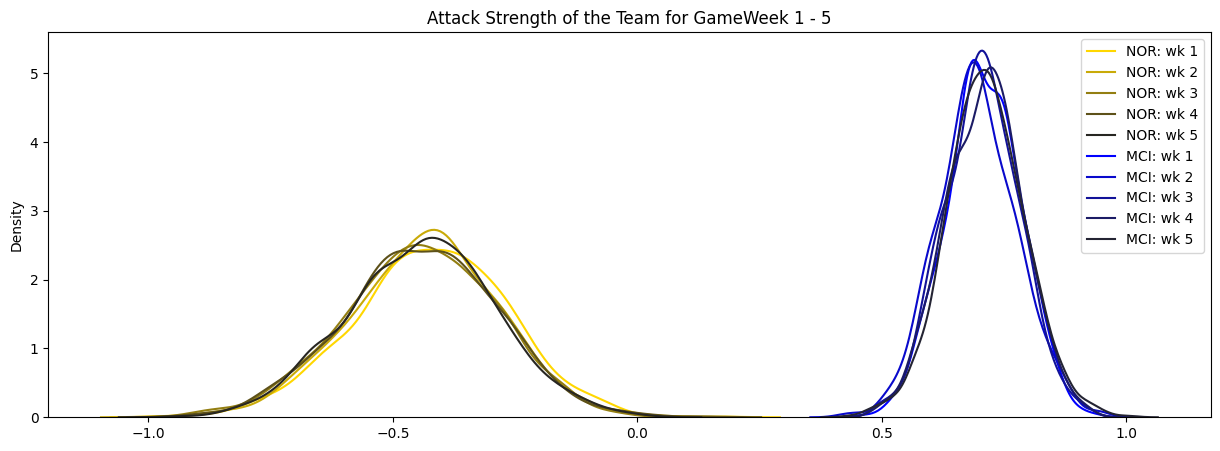

In [14]:
plot_team_attack(no_rate_models, ["NOR", "MCI"])

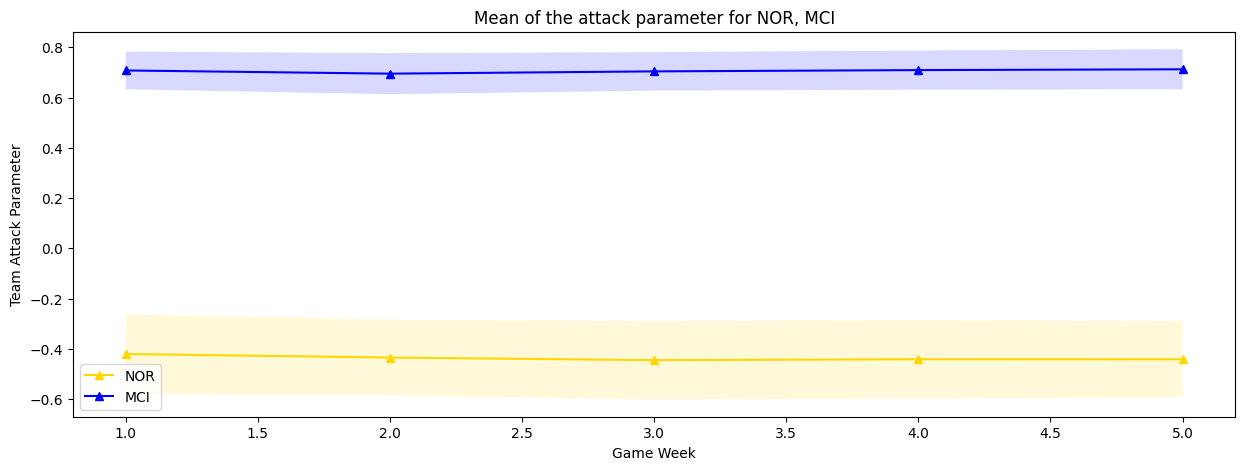

In [15]:
plot_averages(no_rate_models, ["NOR", "MCI"])

## Look at the whole 21/22 Season in 5 week increments using the FIFA ratings

In [16]:
max_game_week = get_max_gameweek(season=season,
                                 dbsession=session)
jump_game_week = list(range(1,max_game_week, 5))

jump_models = {gw: get_fitted_team_model(season, gw, session) for gw in jump_game_week}
teams = get_teams_for_season(season, session)

Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:12<00:00, 119.54it/s, 127 steps of size 4.45e-02. acc. prob=0.94]


Adding BRE to team model with covariates
Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:11<00:00, 126.06it/s, 191 steps of size 4.85e-02. acc. prob=0.93]


Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:11<00:00, 130.97it/s, 127 steps of size 5.06e-02. acc. prob=0.91]


Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:14<00:00, 102.85it/s, 127 steps of size 3.94e-02. acc. prob=0.95]


Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:13<00:00, 113.10it/s, 127 steps of size 4.62e-02. acc. prob=0.93]


Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:14<00:00, 103.90it/s, 127 steps of size 3.67e-02. acc. prob=0.94]


Fitting team model...


sample: 100%|████████████████████████████████████████| 1500/1500 [00:11<00:00, 129.47it/s, 127 steps of size 5.11e-02. acc. prob=0.90]


Fitting team model...


sample: 100%|█████████████████████████████████████████| 1500/1500 [00:15<00:00, 96.59it/s, 127 steps of size 4.00e-02. acc. prob=0.93]


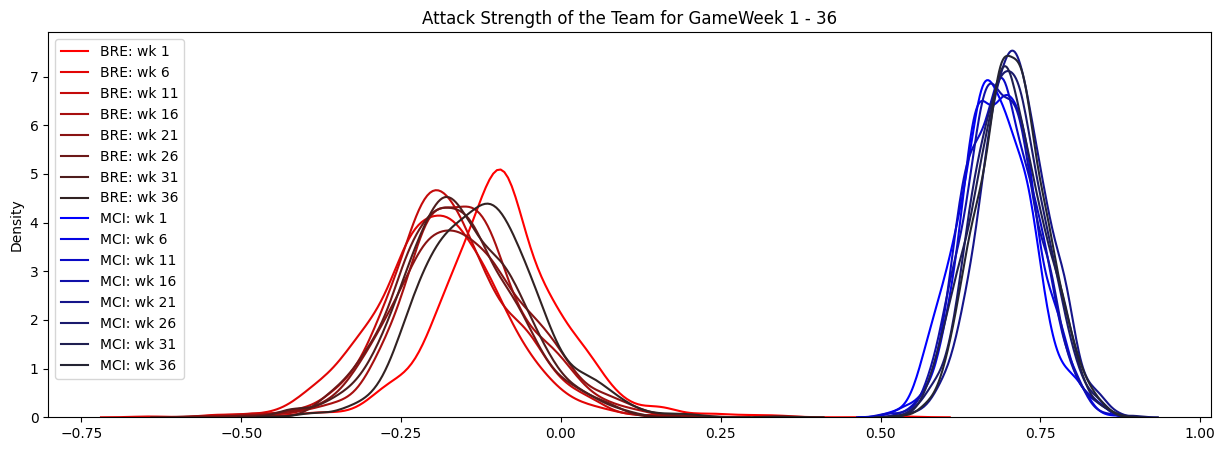

In [17]:
plot_team_attack(jump_models, ["BRE", "MCI"])

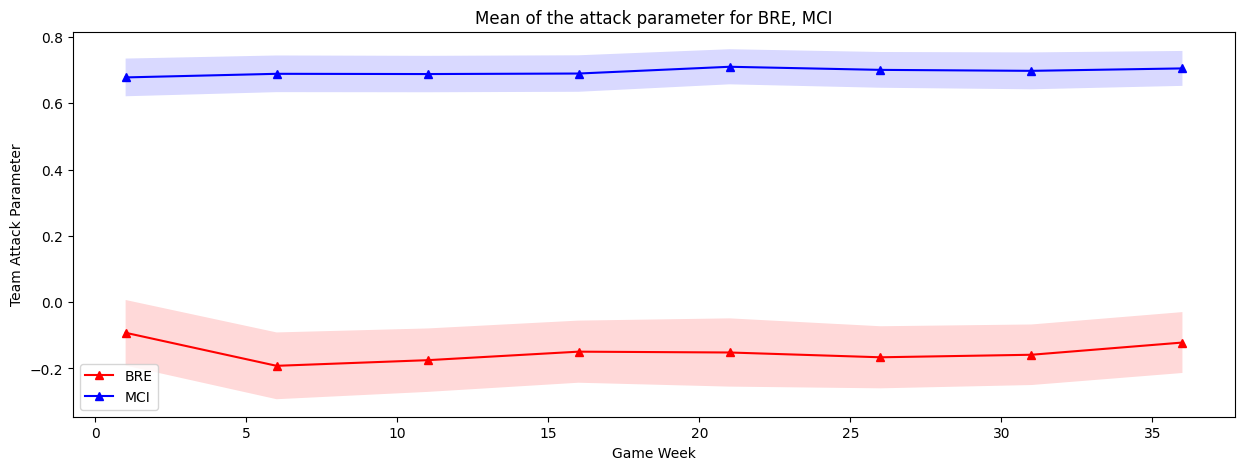

In [18]:
plot_averages(jump_models, ["BRE", "MCI"])

## Whole season no FIFA ratings:

In [19]:
no_rate_jump_models = {}
for gw in jump_game_week:
    # Making the model - this time we use the two preccursor functions from
    # get_fitted_team_model - as we aren't adding new teams
    
    training_data = notebook_get_training_data(season = "2122",
                                      gameweek = gw,
                                      dbsession = session)
    no_rate_jump_models[gw] = create_and_fit_team_model(training_data) 

sample: 100%|█████████████████████████████████████████| 1500/1500 [00:06<00:00, 231.00it/s, 31 steps of size 1.75e-01. acc. prob=0.90]


## Compare effect of including FIFA rating with Norwich

Look at what happens to Norwich with and without the FIFA rating

In [32]:
def compare_models(model_list, team_list):
    ax = plt.figure(figsize=(15, 5)).gca()
    marker_list = ['^', "o", "*", "+"]
    for i, md in enumerate(model_list):
        models_dict = md[0]
        x = list(models_dict.keys())    
        for team in team_list:
            if team not in team_colours.keys():
                team_colours[team] = "gray"
            mean_att = []
            ul = []
            ll = []
            for gw, m in models_dict.items():
                mn = m.attack[:,m.teams.index(team)].mean()
                ul.append(mn + np.std(m.attack[:,m.teams.index(team)]))
                ll.append(mn - np.std(m.attack[:,m.teams.index(team)]))
                mean_att.append(mn)
            plt.plot(x,
                mean_att,
                label=f"{team}: {md[1]}",
                marker=marker_list[i],
                color=team_colours[team]
                )
            plt.fill_between(x, ul, ll, facecolor=team_colours[team], alpha=.15)

    plt.title(f"Mean of the attack parameter for {', '.join(team_list)}")
    plt.xlabel("Game Week")
    plt.ylabel("Team Attack Parameter")

    plt.legend()
    plt.show()
        

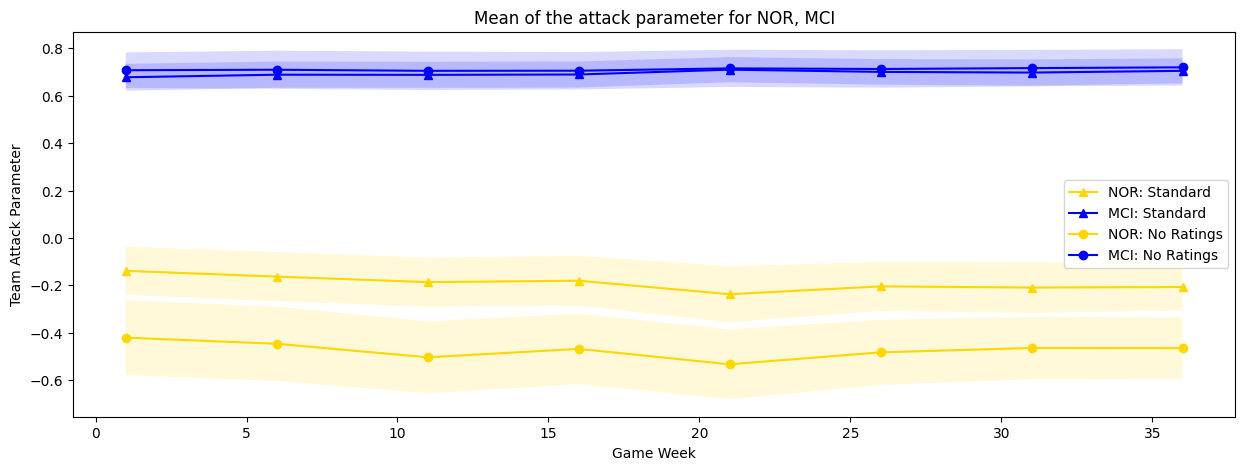

In [40]:
compare_models([(jump_models, "Standard"), (no_rate_jump_models, "No Ratings")], ["NOR", "MCI"])

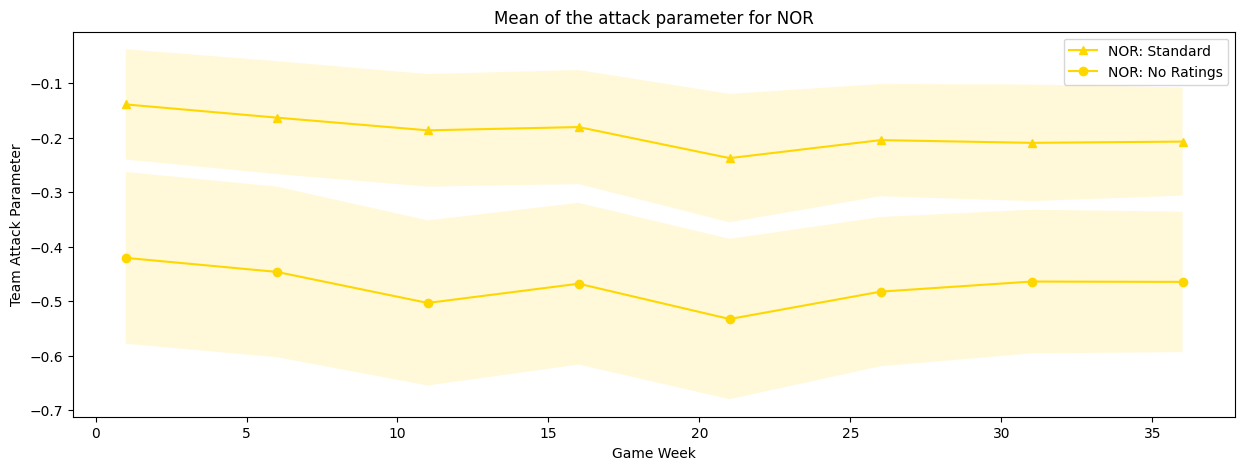

In [41]:
compare_models([(jump_models, "Standard"), (no_rate_jump_models, "No Ratings")], ["NOR"])

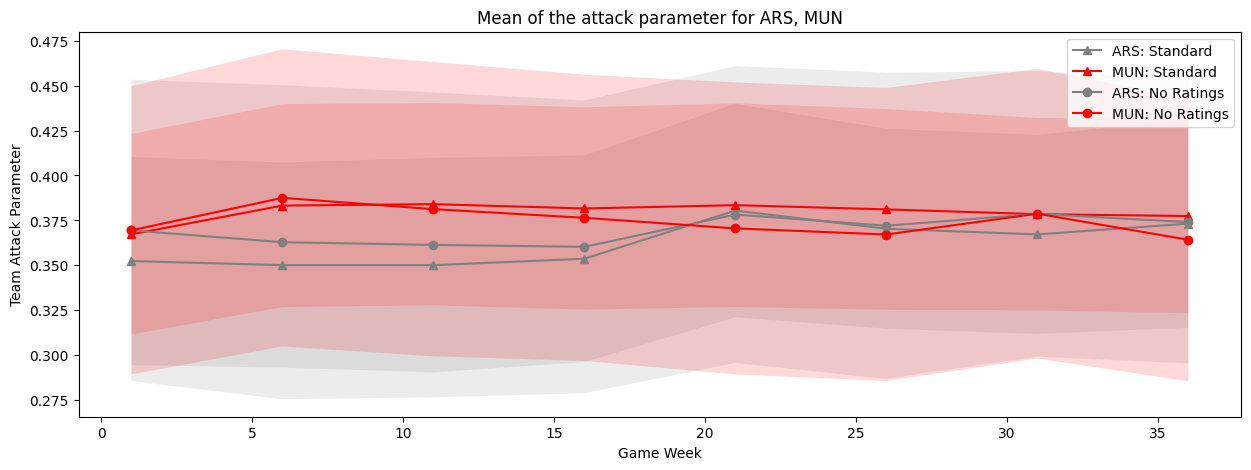

In [50]:
compare_models([(jump_models, "Standard"), (no_rate_jump_models, "No Ratings")], ["ARS", "MUN"])

# Rebuild the database with only 1 year of data 